In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import seaborn as sns


# 0) Load data

In [2]:
train_df = pd.read_pickle("2024_dataset/train_df_with_metadata.pkl")

display(train_df.head(1))

print("Columns: ", train_df.columns)

,encounter_id,image_path,author_id,response_content,query_combined,Time Horizon,Sensation,Body Region,Lesion Morphology,Lesion Surface Features,...,b_mean,r_std,g_std,b_std,response_char_count,response_word_count,response_token_length,query_char_count,query_word_count,query_token_length
0,ih99w9,2024_dataset\images\train\ih99w9.jpg,annotator1,"Most probably it is a case of inflamed pimple,...",I had this mole that appeared under my eye abo...,less than a week,none,face,raised bump,smooth,...,116.716689,39.960184,43.285325,47.200678,244,46,56,256,49,62


Columns:  Index(['encounter_id', 'image_path', 'author_id', 'response_content',
       'query_combined', 'Time Horizon', 'Sensation', 'Body Region',
       'Lesion Morphology', 'Lesion Surface Features', 'Lesion Fullness',
       'Lesion Size', 'Color Description', 'Distribution Pattern', 'Diagnosis',
       'Diagnostic Confidence', 'Image Description', 'error',
       'query_combined_embedding', 'response_content_embedding', 'image_width',
       'image_height', 'r_mean', 'g_mean', 'b_mean', 'r_std', 'g_std', 'b_std',
       'response_char_count', 'response_word_count', 'response_token_length',
       'query_char_count', 'query_word_count', 'query_token_length'],
      dtype='object')


# 1) Data Preprocessing

In [3]:
# Define annotator mapping for relabeling
annotator_mapping = {
    "annotator1": "Annotator 1",
    "annotator2": "Annotator 2",
    "annotator3": "Annotator 3"
}

# Relabel the 'author_id' column in the DataFrame
train_df["author_id"] = train_df["author_id"].map(annotator_mapping)

In [4]:
train_df.head()

,encounter_id,image_path,author_id,response_content,query_combined,Time Horizon,Sensation,Body Region,Lesion Morphology,Lesion Surface Features,...,b_mean,r_std,g_std,b_std,response_char_count,response_word_count,response_token_length,query_char_count,query_word_count,query_token_length
0,ih99w9,2024_dataset\images\train\ih99w9.jpg,Annotator 1,"Most probably it is a case of inflamed pimple,...",I had this mole that appeared under my eye abo...,less than a week,none,face,raised bump,smooth,...,116.716689,39.960184,43.285325,47.200678,244,46,56,256,49,62
1,11n62qx,2024_dataset\images\train\11n62qx.jpg,Annotator 1,"Most probably it is a case of solar lentigo, a...",Spot in my hairline,unknown,none,scalp,flat,smooth,...,108.012621,73.668586,54.968795,53.001518,636,100,126,19,4,5
2,vk578x,2024_dataset\images\train\vk578x.jpg,Annotator 1,Most propably it is a case of a cyst in the gr...,Can someone help me ID this random bump? Today...,['less than a week'],['none'],['groin'],['raised bump'],['smooth'],...,60.220579,19.354914,17.989976,14.696659,518,90,111,251,53,67
3,123bko0,2024_dataset\images\train\123bko0.jpg,Annotator 1,It is a case of common wart. This noncancerous...,Rough bump/spot on the side of finger? What ex...,['unknown'],['none'],['fingers'],['raised bump'],['rough'],...,121.996917,49.473475,51.857590,47.409974,1336,236,303,86,15,22
4,11m0l9c,2024_dataset\images\train\11m0l9c.jpg,Annotator 1,Most probably it is a case of deep coarse wrin...,Puffy line on face any suggestions?,['unknown'],['none'],['face'],['flat'],['rough'],...,128.426929,33.930166,35.166915,33.532767,791,117,178,35,6,8


In [5]:
def clean_column_values(value):
    if isinstance(value, str):
        try:
            parsed_value = ast.literal_eval(value)
            if isinstance(parsed_value, list):
                return ", ".join(parsed_value)  
        except (ValueError, SyntaxError):
            pass  
    return value  

columns_to_clean = [
    'Time Horizon', 'Sensation', 'Body Region', 'Lesion Morphology', 
    'Lesion Surface Features', 'Lesion Fullness', 'Lesion Size', 
    'Color Description', 'Distribution Pattern', 'Diagnosis', 
    'Diagnostic Confidence', 'Image Description'
]

for col in columns_to_clean:
    train_df[col] = train_df[col].apply(clean_column_values)

# 2) EDA of LLM-generated metadata

In [6]:
def plot_category_counts(df, column_name, title, color=(77/255, 129/255, 163/255), top_n=None):
    counts = df[column_name].value_counts()

    if column_name == "author_id":
        counts = counts.reindex(["Annotator 1", "Annotator 2", "Annotator 3"])

    if top_n:
        counts = counts.nlargest(top_n)

    rotate_x_labels = len(counts) >= 5  

    plt.figure(figsize=(10, 6))
    bars = plt.bar(counts.index, counts.values, color=color)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, str(int(height)), 
                 ha='center', va='bottom', fontsize=14, fontweight='bold')

    plt.ylabel("Count", fontsize=16)
    plt.title(title, fontsize=16)

    if rotate_x_labels:
        plt.xticks(rotation=45, fontsize=14)
    else:
        plt.xticks(fontsize=14)

    plt.show()

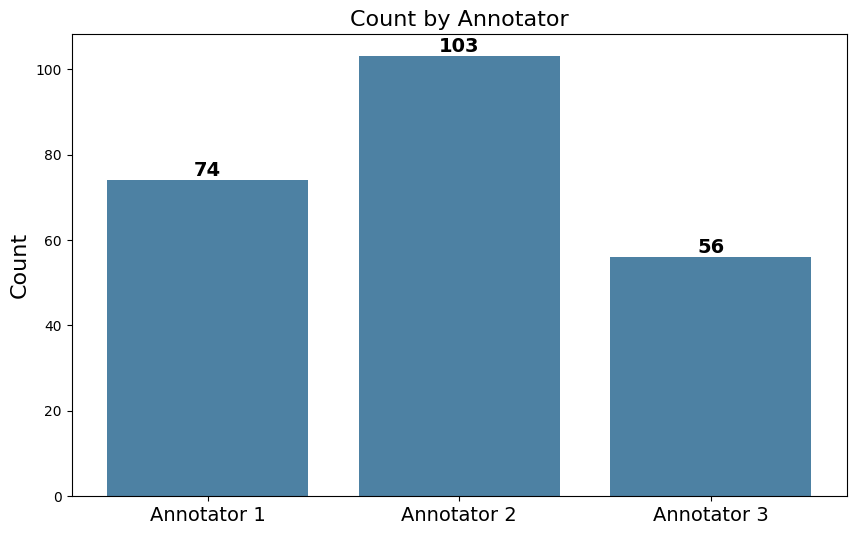

In [7]:
plot_category_counts(train_df, "author_id", "Count by Annotator")

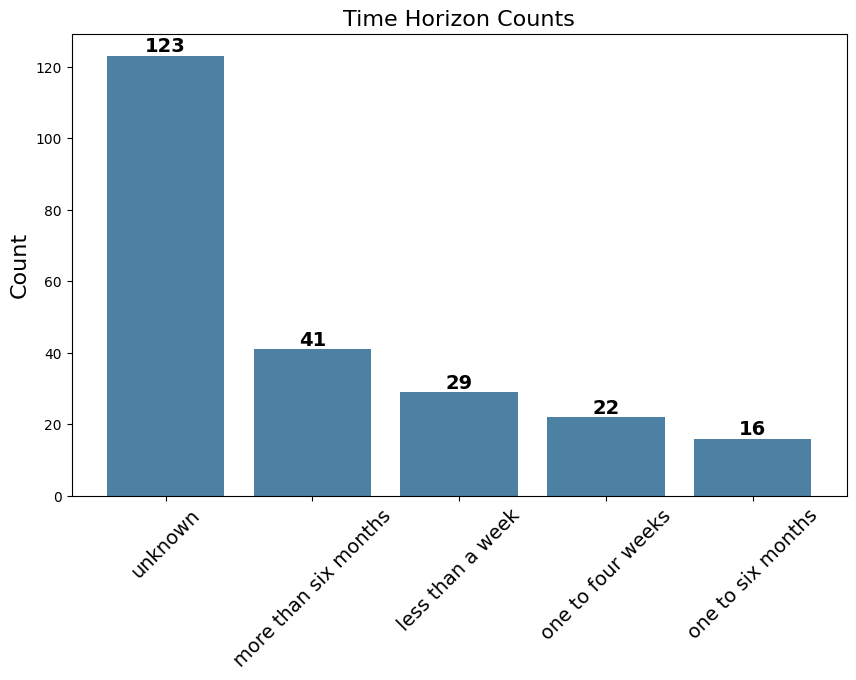

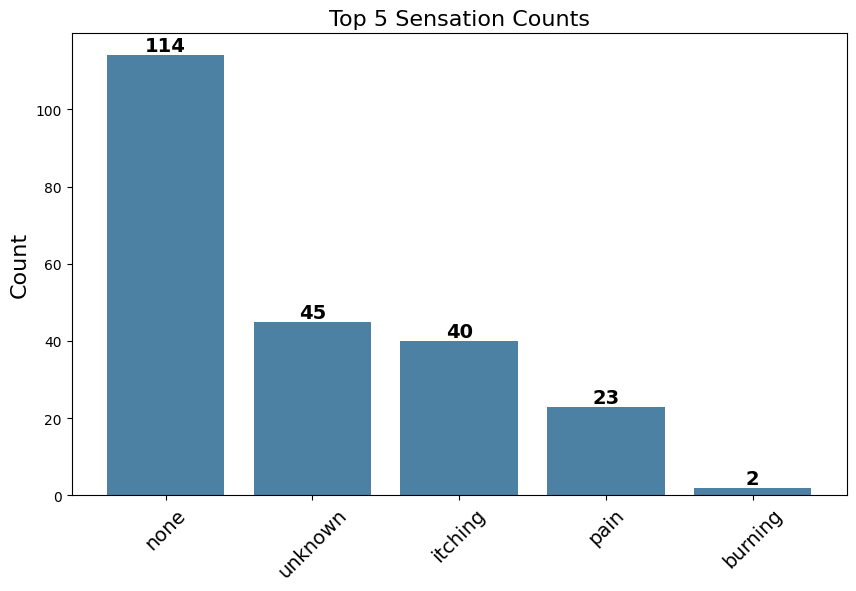

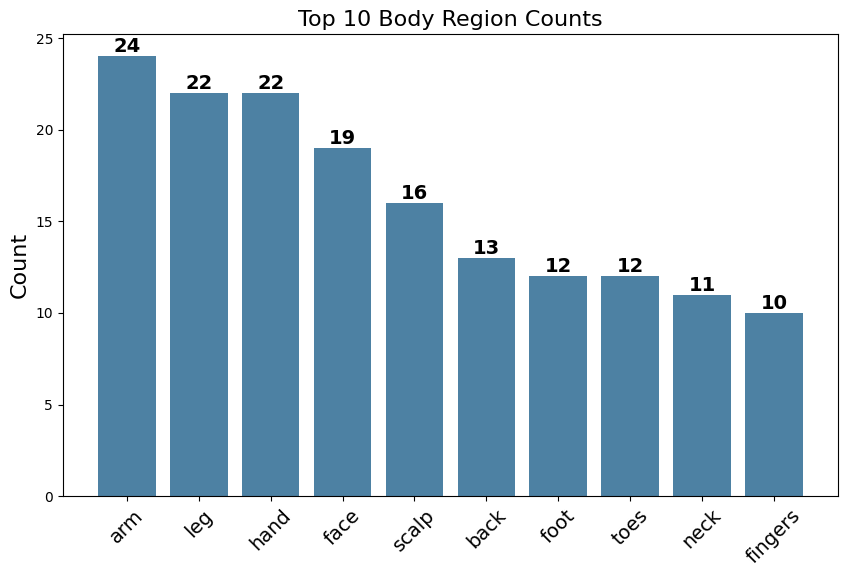

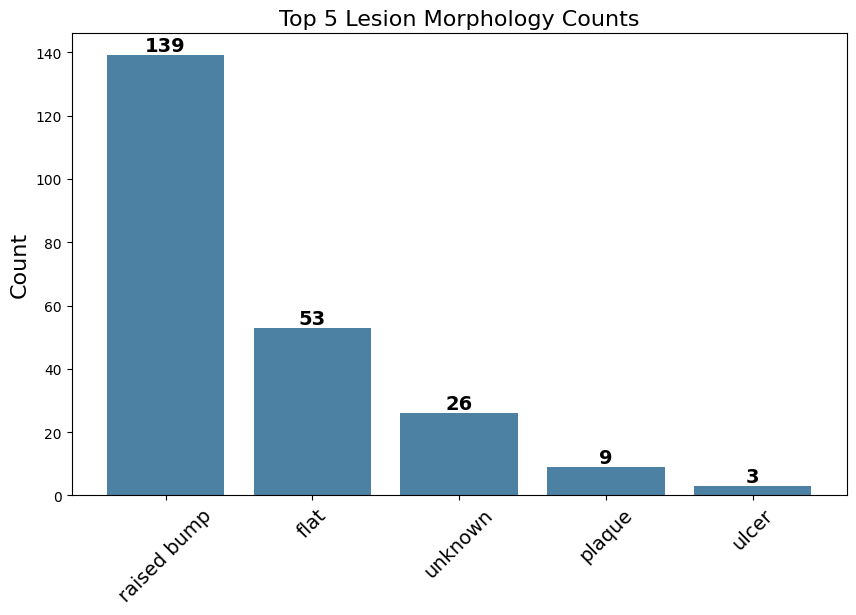

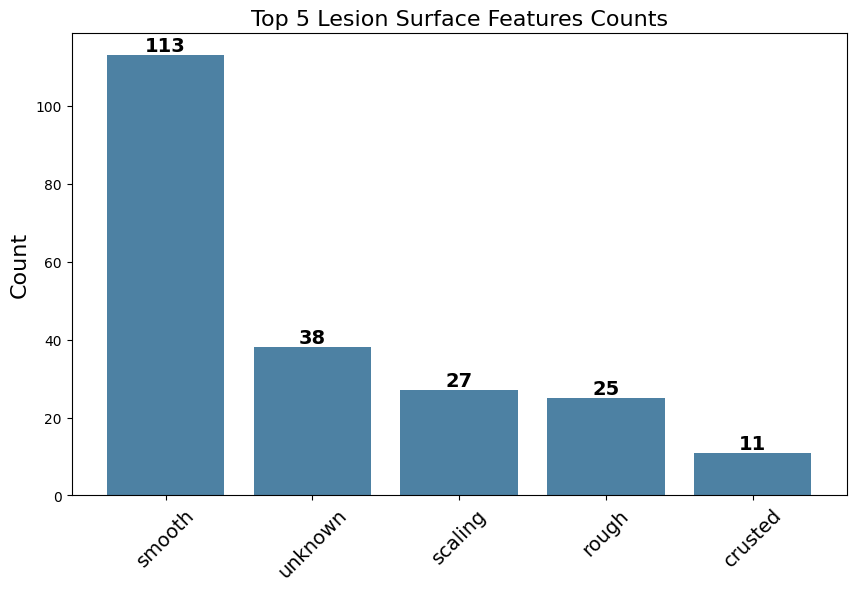

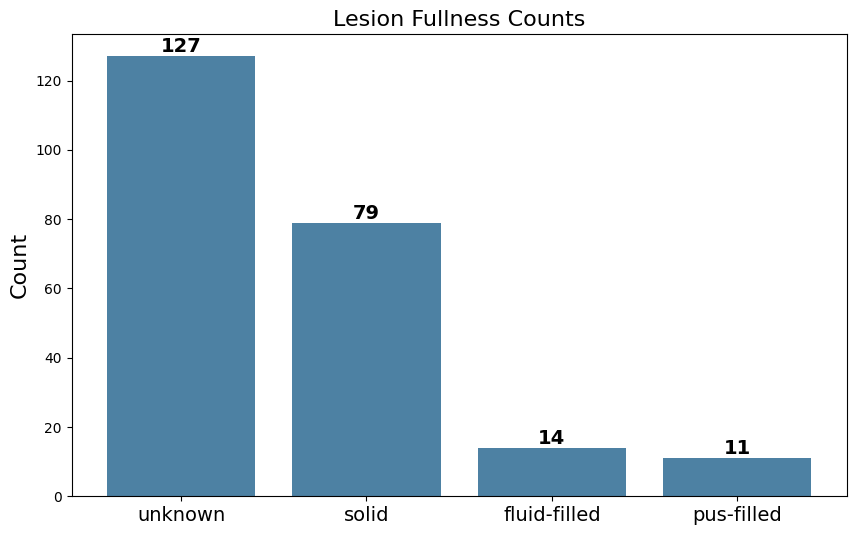

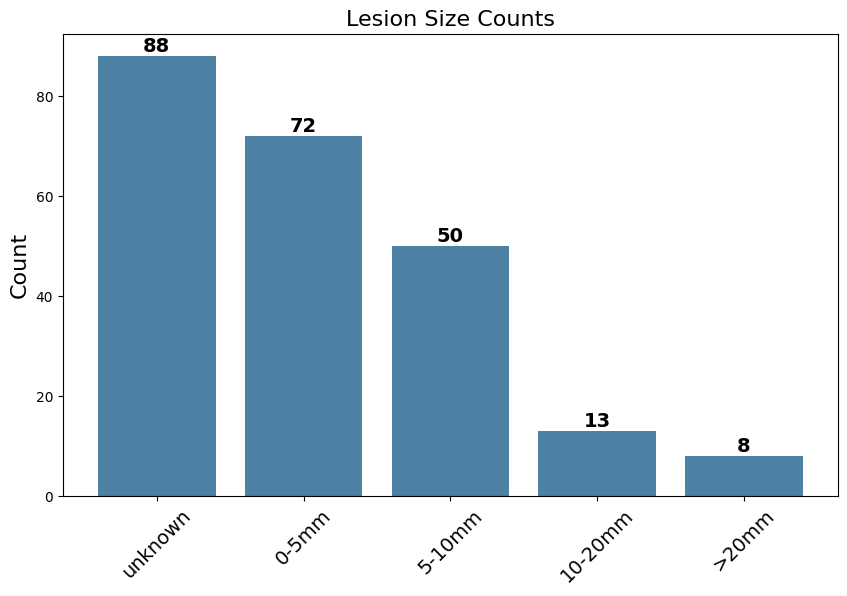

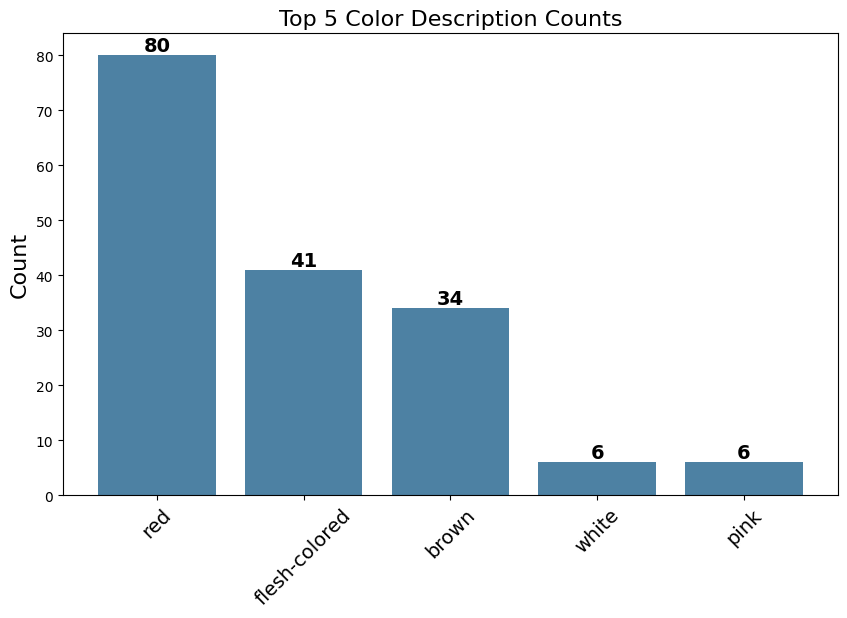

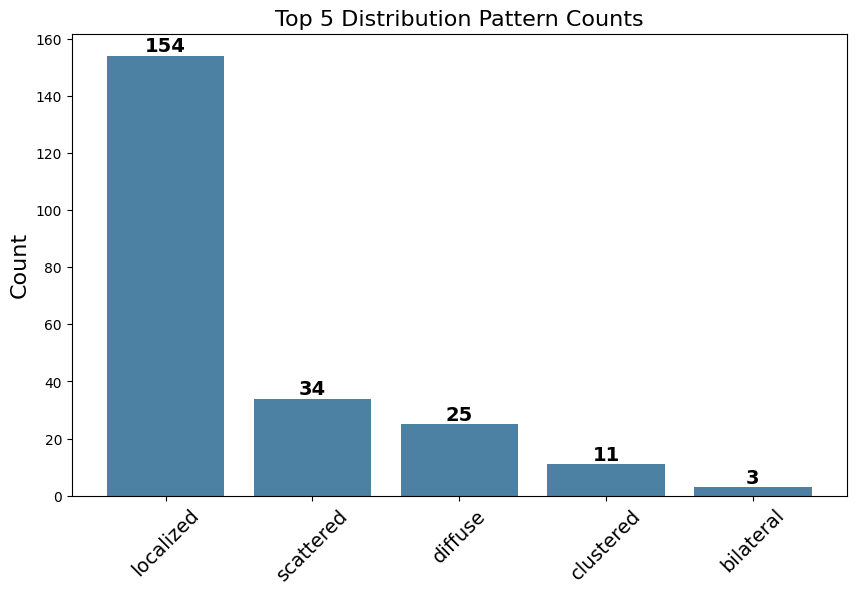

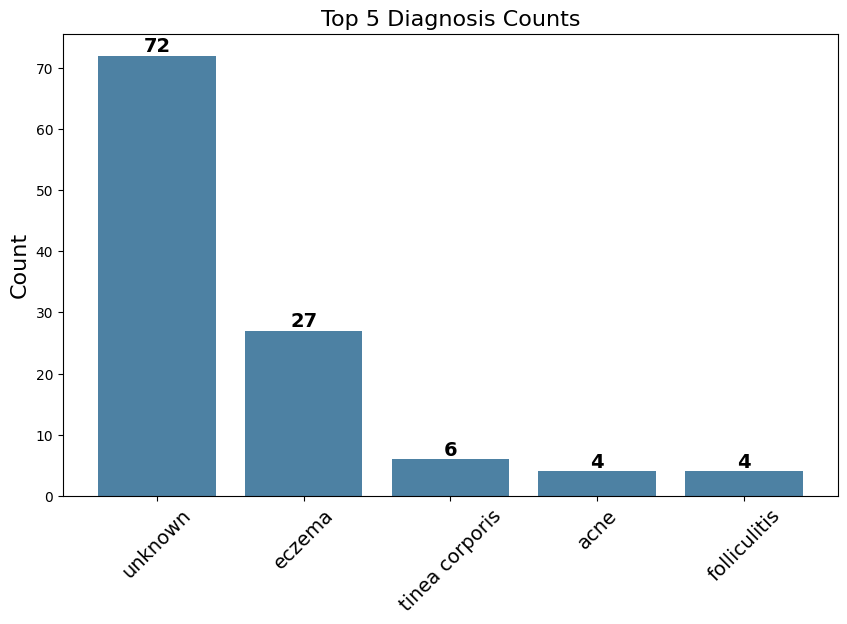

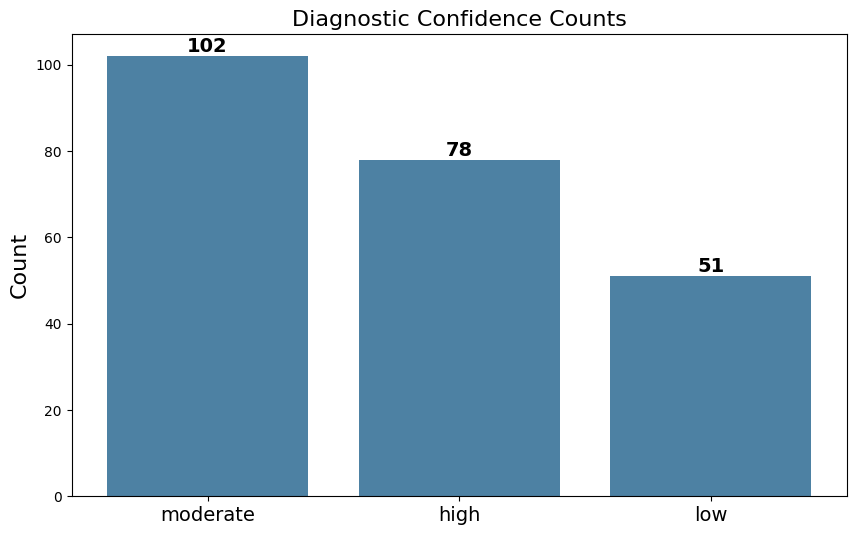

In [15]:
columns_to_visualize = [
    'Time Horizon', 'Sensation', 'Body Region', 'Lesion Morphology', 
    'Lesion Surface Features', 'Lesion Fullness', 'Lesion Size', 
    'Color Description', 'Distribution Pattern', 'Diagnosis', 
    'Diagnostic Confidence'
]

for col in columns_to_visualize:
    if col in ['Sensation', 'Color Description', 'Distribution Pattern', 'Diagnosis', 'Lesion Morphology', 'Lesion Surface Features']:
        plot_category_counts(train_df, col, f"Top 5 {col} Counts", top_n=5)
    elif col == 'Body Region':
        plot_category_counts(train_df, col, f"Top 10 {col} Counts", top_n=10)
    else:
        plot_category_counts(train_df, col, f"{col} Counts")

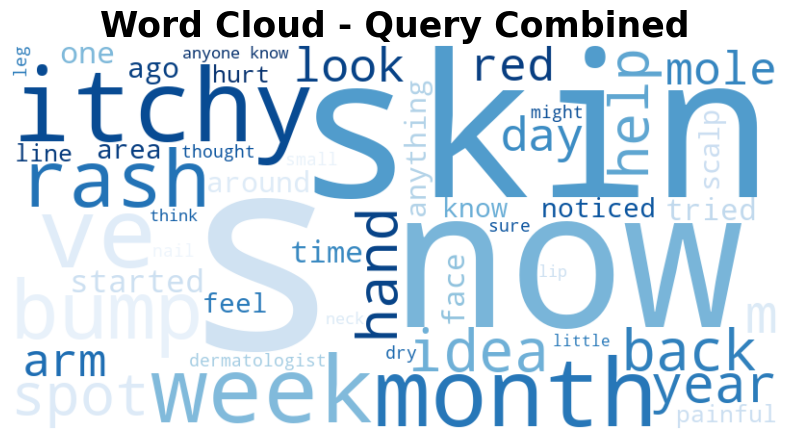

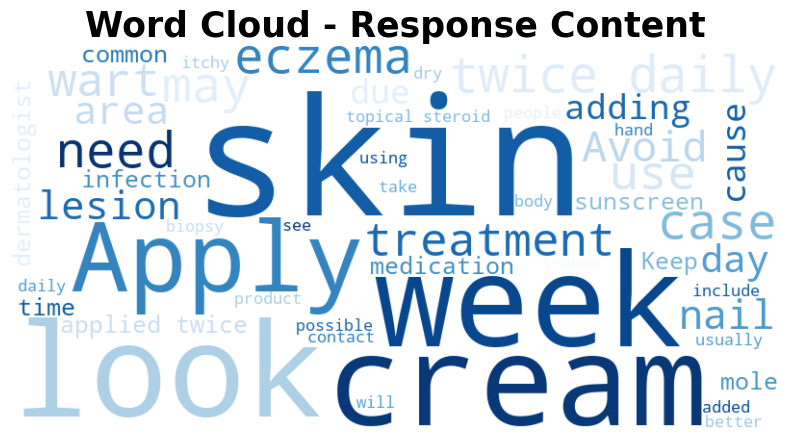

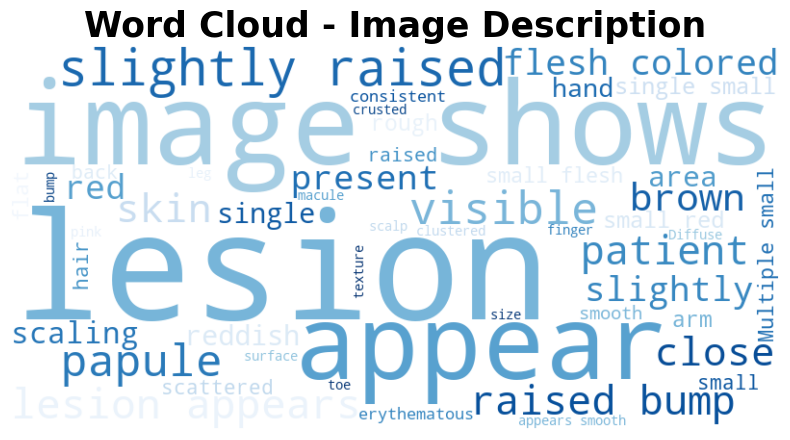

In [42]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='Blues', max_words=50).generate(" ".join(text.dropna()))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=25, fontweight='bold')
    plt.show()

plot_wordcloud(train_df["query_combined"], "Word Cloud - Query Combined")
plot_wordcloud(train_df["response_content"], "Word Cloud - Response Content")
plot_wordcloud(train_df["Image Description"], "Word Cloud - Image Description")

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [18]:
unknown_diagnosis_df = train_df[train_df['Diagnosis'] == 'unknown'][['response_content']]

display(unknown_diagnosis_df.head(10)) # Several require dermatological evaluation to determine diagnosis

,response_content
17,"Raised bumps on the skin can have many different causes, ranging from acne to skin cancer according to onset, duration and recent changes. Most propably it is a case of irritated mole. You may need to be checked by your health care provider for more accurate diagnosis and skin biopsy if needed."
25,"Most propably these are scartch marks due to itchy skin. Itchy skin may be due to dry skin, atopic dermatitis, or contact dermatitis. Try using over the counter fragrance free moisturizers containing hyaluronic acid, bees wax, ceramides or shea butter to improve your skin barrier defect and relieve itching. You can also try to use soap free cleansers to avoid more irritation. Topical hydrocortisone may be also used."
36,"The most possible diagnosis is a birthmark especially that it lacks any symptom of itching or dicomfort. Other possible causes of rash include eczema (mostly in atopic dermatitis), contact dermatitis (if he is allergic or sensitive to a new soap, lotion, or laundry detergent), chafing (by the frequent friction of skin rubbing against the skin from walking, running, or exercising), or heat rash (in hot weather or following a strenuous workout). Referral to a dermatologist for more accurate diagnosis is needed. No need for treatment in case it is a birthmark, while other treatment options include bathing in warm (not hot) water, using a regular moisturizer containing aloe vera, petroleum jelly or shea butter, avoiding harsh scents or products, using topical medications like topical corticosteroid cream, and cool compresses"
41,"You need to see a dermatologist for dermoscopic examination of this lesion and skin biopsy if needed. The dermoscopic examination is a useful adjunct for pigmented lesions to help identify worrisome pigment patterns. Regular self-examinations of your skin will help you detect a difference in a mole over time. An easy way to remember how to check your skin is to use the ABCDE technique to identify changes.\nAsymmetry - Each half of the mole is a different shape\nBorder - Look for spreading or irregular edges\nColour - A recent change or blotchy spots with many colors\nDiameter - Spots are getting bigger \nEvolving - Changing or growing in size, shape or thickness."
49,"It doesn't seem like a wart rather it seems like a healing wound. Try to apply moisturizer containing panthenol, petrolatum, shea butter, or beeswax to speed up the healing process. If it is still persistent you can consult your dermatologist to rule out the presence of a wart using dermoscopic examination."
51,"You need to see a dermatologist for dermoscopic examination of this lesion and skin biopsy if needed. The dermoscopic examination is a useful adjunct for pigmented lesions to help identify worrisome pigment patterns. Regular self-examinations of your skin will help you detect a difference in a mole over time. An easy way to remember how to check your skin is to use the ABCDE technique to identify changes.\nAsymmetry - Each half of the mole is a different shape\nBorder - Look for spreading or irregular edges\nColor - A recent change or blotchy spots with many colors\nDiameter - spots are getting bigger \nEvolving - Changing or growing in size, shape, or thickness."
60,"You need to see a dermatologist for dermoscopic examination of this lesion and skin biopsy if needed. The dermoscopic examination is a useful adjunct for pigmented lesions to help identify worrisome pigment patterns. Regular self-examinations of your skin will help you detect a difference in a mole over time. An easy way to remember how to check your skin is to use the ABCDE technique to identify changes.\nAsymmetry - Each half of the mole is a different shape\nBorder - Look for spreading or irregular edges\nColour - A recent change or blotchy spots with many colours\nDiameter - spots are getting bigger \nEvolving - Changing or growing in size, shape or thickness. If you noticed any change consulting your dermatologist is recommended."


In [21]:
error_records = train_df[train_df["error"].notna()]

error_records

# LLM guardrails avoided responses to this record

,encounter_id,image_path,author_id,response_content,query_combined,Time Horizon,Sensation,Body Region,Lesion Morphology,Lesion Surface Features,Lesion Fullness,Lesion Size,Color Description,Distribution Pattern,Diagnosis,Diagnostic Confidence,Image Description,error,query_combined_embedding,response_content_embedding,image_width,image_height,r_mean,g_mean,b_mean,r_std,g_std,b_std,response_char_count,response_word_count,response_token_length,query_char_count,query_word_count,query_token_length
111,127c0ze,2024_dataset\images\train\127c0ze.jpg,Annotator 3,"It is not clear based on just this picture what this rash is on your child's body. However, it could be a condition related to the mast cells in the skin, residual inflammatory pigment changes, or hives. Your child should be seen by a dermatologist to investigate further and may need a biopsy or antihistamines to help. It may require avoidance of certain medications such as aspirin, anticholinergics, codeine, polymyxin B, and anesthetics to prevent systemic symptoms. If your child has systemic symptoms such as diarrhea, flushing, or shortness of breath then it may require bloodwork and genetic testing.",My 2 year old has this rash on his whole body. What could it be?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Error processing image: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.\nThis appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: PROHIBITED_CONTENT\n","[-0.0048534535, 0.04688981, -0.013665245, -0.015916586, -0.013607417, -0.032049824, -0.03953321, 0.059563197, -0.00023274001, -0.012887614, -0.008589184, 0.098698534, -0.039776772, -0.013709439, 0.026845228, 0.024971256, -0.010600789, -0.024756202, -0.055269282, 0.010814173, 0.009785254, -0.0014601488, -0.0023560105, 0.0066974214, -0.03556128, 0.042002194, -0.0071931947, -0.026868781, 0.0030223352, 0.005640115, -0.032609455, -0.03680903, 0.04027978, -0.043398134, 0.00043605934, -0.0528637, -0.007594697, 0.021905951, -0.005164259, -0.0065392056, -0.018673562, 0.022967301, 0.037838235, -0.00019471104, 0.0047860374, -0.0134785585, -0.017871413, -0.019422943, 0.0024075601, -0.022805534, -0.041951638, 0.00818623, -0.011027609, -0.031150334, 0.007939385, -0.0118709635, 0.06790254, 0.0068723625, -0.028591251, -0.039695166, 0.0073622703, -0.0005134986, -0.006872065, 0.016319217, 0.015535295, 0.109222054, -0.005128795, 0.008173736, -0.0080263745, -0.009279889, -0.04624514, 0.0069942707, -0.012908738, -0.007756186, -0.048158728, 0.009616823, 0.015188826, 0.02222281, -0.018206824, 0.026954353, 0.05687006, -0.015922304, -0.044448137, 0.061369356, -0.0118838735, 0.061510026, -0.027777221, -0.03801174, -0.020682039, 0.0057424875, -0.024516795, -0.013649185, 0.026652157, -0.025101064, -0.028503532, 0.04724495, -0.02584213, -0.025052033, 0.045168962, -0.0063052406, ...]","[0.009827803, 0.030416768, -0.026293056, -0.019912008, -0.026317243, -0.022922387, -0.011779147, 0.083981395, 0.005070031, -0.011835313, -0.013026845, 0.04807781, -0.013449415, -0.0095329685, -0.006653245, -6.272184e-05, -0.03534755, -0.029461129, -0.028133247, 0.009484501, 0.009176607, -0.03286079, 0.019198278, -0.025942389, -0.051591344, 0.040891606, -0.00227612, -0.025774367, 0.0036881894, -0.014748015, -0.00791187, -0.0659474, 0.08418068, -0.05719472, -0.039724167, -0.07530403, -0.03494744, 0.034811288, -0.008006367, -0.013652712, -0.0067638834, 0.018722124, 0.037805345, 0.04684083, -0.022344327, -0.021101786, -0.027782789, -0.020977108, 0.01410146, -0.019096423, -0.027413938, -0.024444385, -0.0024212736, -0.04006992, -0.024904396, -0.026790902, 0.059986893, -0.03371239, -0.0059835655, -0.00450365, -0.013688239, 0.008776631, -0.029188938, -0.008706916, 0.011653413, 0.07913746, 0.016044594, 0.028811447, -0.03258234, -0.05131075, -0.04439934, -0.0039806524, -0.0217071, -0.033712495, -0.032948907, 0.00496391, 0.0063802446, -0.010270708, 0.0034589267, 0.

# 3) EDA of embeddings data

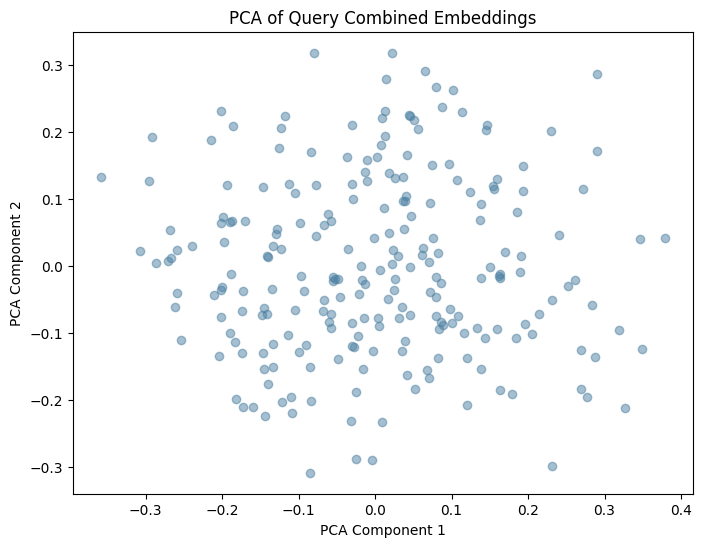

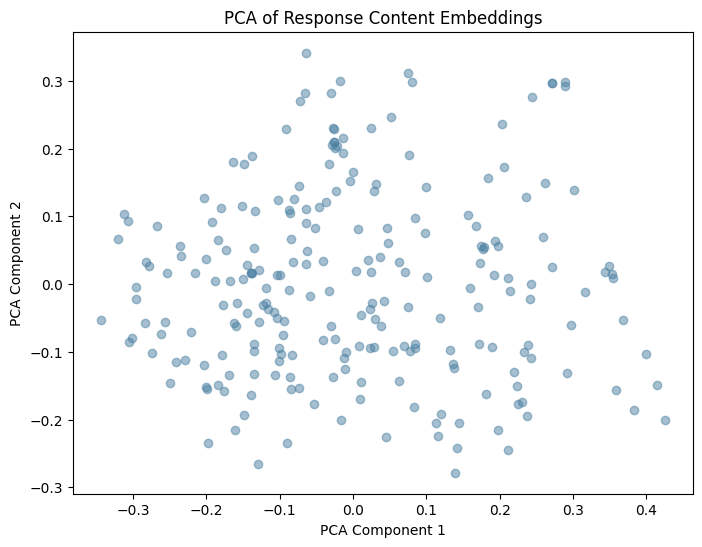

In [23]:
def visualize_pca_embeddings(df, column_name, title):
    embeddings = df[column_name].dropna().tolist()
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5, color=(77/255, 129/255, 163/255))
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.show()

visualize_pca_embeddings(train_df, 'query_combined_embedding', 'PCA of Query Combined Embeddings')
visualize_pca_embeddings(train_df, 'response_content_embedding', 'PCA of Response Content Embeddings')

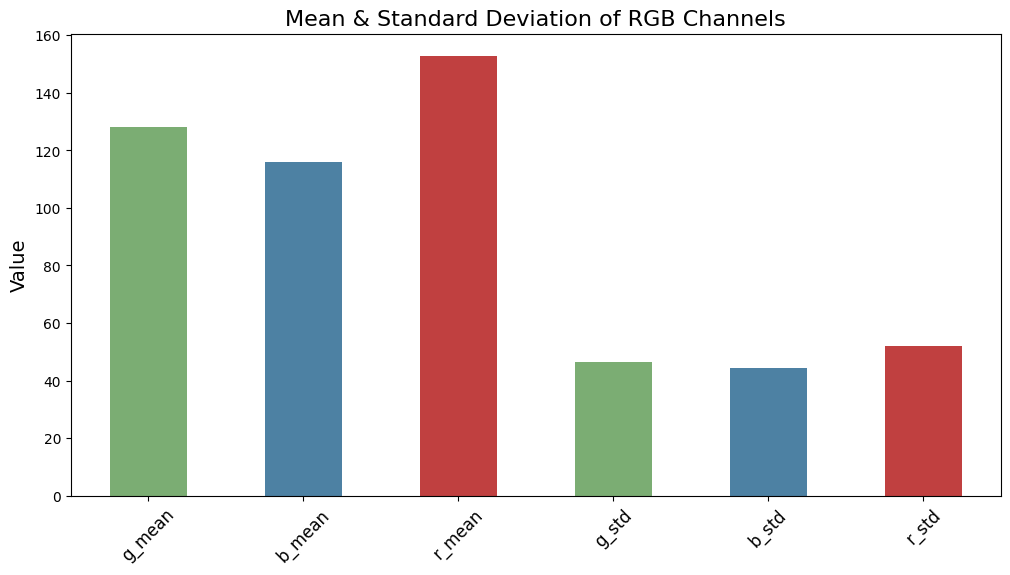

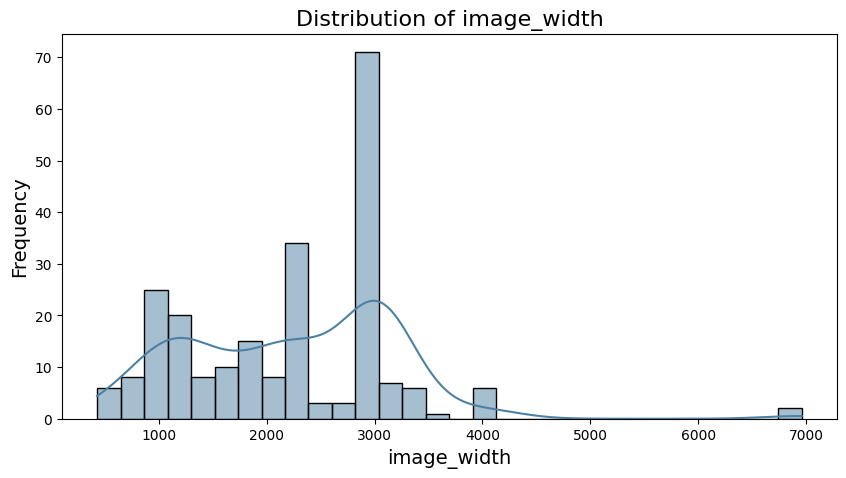

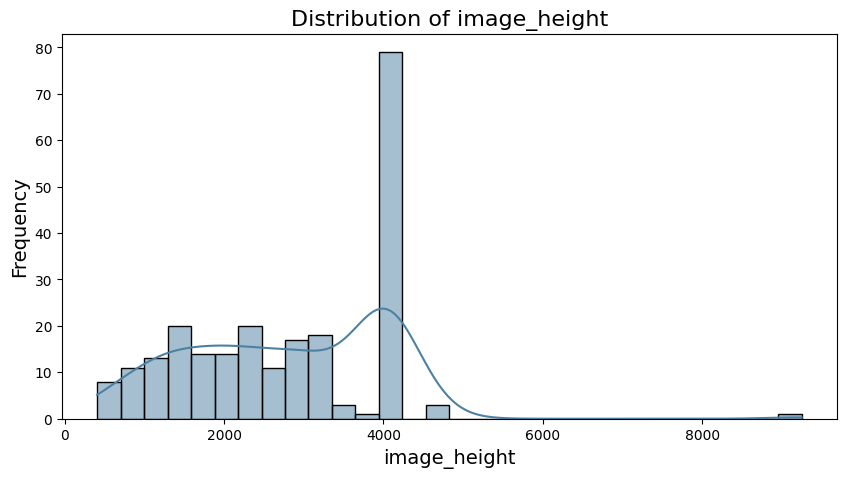

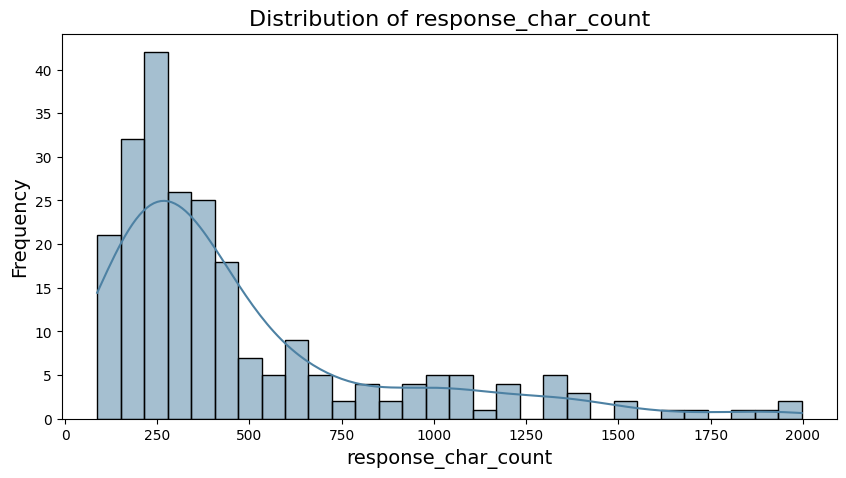

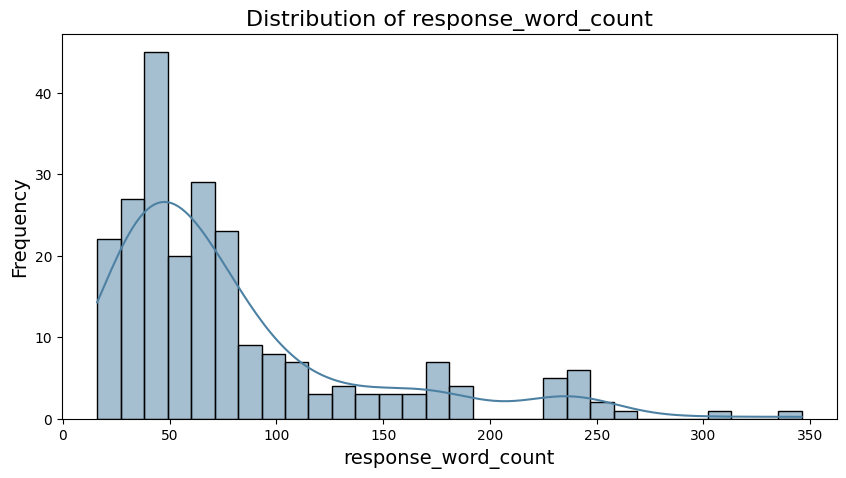

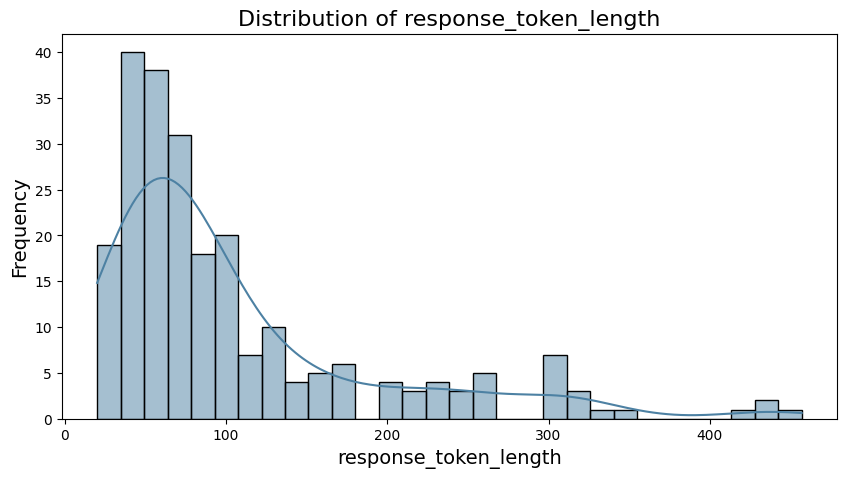

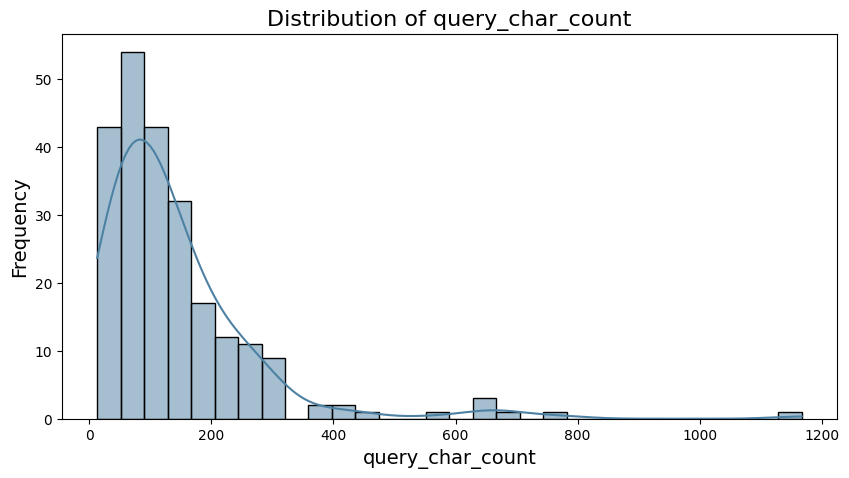

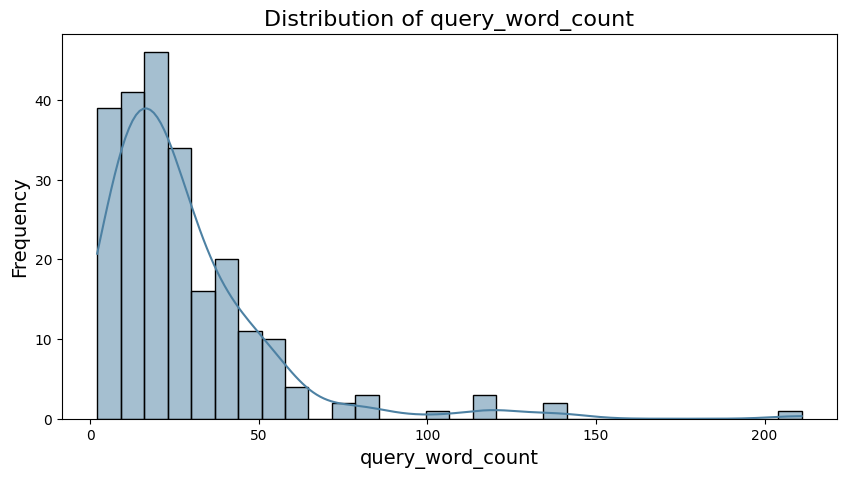

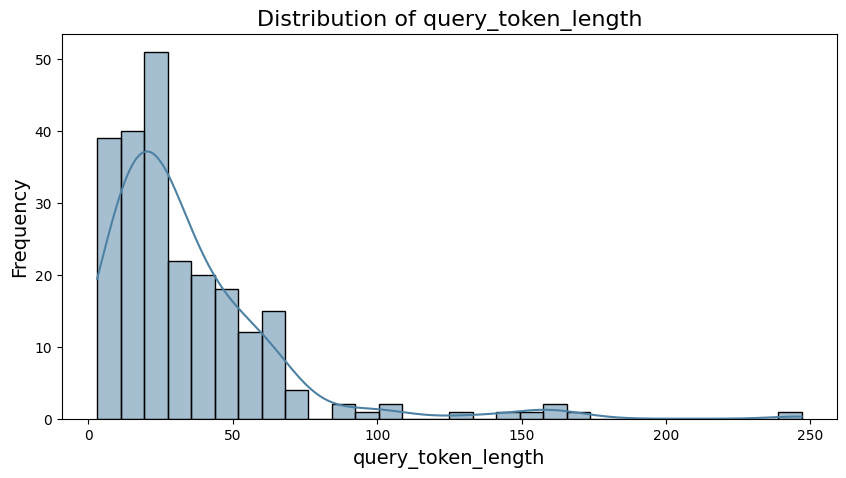

In [45]:
# Define custom colors for RGB visualization
colors = [
    (123 / 255, 173 / 255, 115 / 255),  # Green
    (77 / 255, 129 / 255, 163 / 255),   # Blue
    (192 / 255, 64 / 255, 64 / 255)     # Red
]

# Plot RGB Mean & Std together
rgb_mean_std = train_df[['g_mean', 'b_mean', 'r_mean', 'g_std', 'b_std', 'r_std']]
plt.figure(figsize=(12, 6))
rgb_mean_std.mean().plot(kind='bar', color=colors * 2)
plt.title("Mean & Standard Deviation of RGB Channels", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

# Individual visualizations for numeric columns
columns_to_plot = [
    'image_width', 'image_height',
    'response_char_count', 'response_word_count', 'response_token_length',
    'query_char_count', 'query_word_count', 'query_token_length'
]

for col in columns_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(train_df[col], bins=30, kde=True, color=(77 / 255, 129 / 255, 163 / 255))
    plt.title(f"Distribution of {col}", fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

In [46]:
# Compute and print mean values for the selected columns
columns_to_compute_means = [
    'image_width', 'image_height',
    'response_char_count', 'response_word_count', 'response_token_length',
    'query_char_count', 'query_word_count', 'query_token_length'
]

mean_values = train_df[columns_to_compute_means].mean()

print(mean_values)

image_width              2242.605150
image_height             2776.557940
response_char_count       476.605150
response_word_count        79.223176
response_token_length     105.184549
query_char_count          141.236052
query_word_count           27.351931
query_token_length         34.240343
dtype: float64
